In [12]:
!pip install torch torchvision torchaudio
!pip install transformers datasets scikit-learn
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.5 MB/s eta 0:00:00


In [13]:
from datasets import load_dataset

# Load the IMDB dataset
dataset = load_dataset("imdb")

# See what’s inside
print(dataset)
print(dataset["train"][0])  # show first review


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and

In [14]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# Apply tokenizer to the full dataset
tokenized_dataset = dataset.map(tokenize, batched=True)

print( tokenized_dataset)

# Set PyTorch format
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})


In [15]:
from torch.utils.data import DataLoader

# Training and test datasets
train_dataset = tokenized_dataset["train"]
test_dataset = tokenized_dataset["test"]

# Batch size
batch_size = 16

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [16]:
from transformers import BertForSequenceClassification

# Load pretrained BERT with a classification head for 2 classes
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [17]:
from torch.optim import SGD

# 7️⃣ Optimizer (SGD as requested)
optimizer = SGD(model.parameters(), lr=0.01)


In [18]:
# 8️⃣ Training Loop
epochs = 2

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass + compute loss internally
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backprop + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 200 == 0:  # print every 200 batches
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} finished. Average Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Batch 0, Loss: 0.6520
Epoch 1, Batch 200, Loss: 0.4813
Epoch 1, Batch 400, Loss: 0.6338
Epoch 1, Batch 600, Loss: 0.4642
Epoch 1, Batch 800, Loss: 0.5933
Epoch 1, Batch 1000, Loss: 0.4161
Epoch 1, Batch 1200, Loss: 0.1908
Epoch 1, Batch 1400, Loss: 0.3415
Epoch 1 finished. Average Loss: 0.3860
Epoch 2, Batch 0, Loss: 0.7649
Epoch 2, Batch 200, Loss: 0.2824
Epoch 2, Batch 400, Loss: 0.2003
Epoch 2, Batch 600, Loss: 0.1134
Epoch 2, Batch 800, Loss: 0.1402
Epoch 2, Batch 1000, Loss: 0.1519
Epoch 2, Batch 1200, Loss: 0.6202
Epoch 2, Batch 1400, Loss: 0.2746
Epoch 2 finished. Average Loss: 0.2771


In [19]:
# 9️⃣ Evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = outputs.logits.argmax(dim=1)

        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8736


Test Accuracy: 0.8736
Test Error Rate: 0.1264


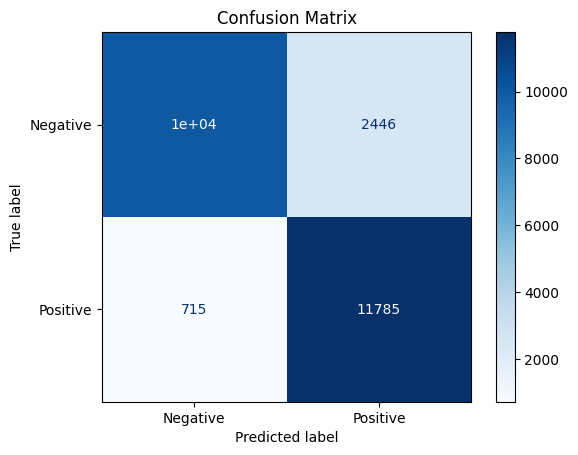

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = logits.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Compute accuracy and error rate
correct = sum([p == l for p, l in zip(all_predictions, all_labels)])
total = len(all_labels)
accuracy = correct / total
error_rate = 1 - accuracy

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Error Rate: {error_rate:.4f}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
